# Neyron Tarmoqlari

---

- `h5py` kutubxonasi - https://docs.h5py.org/en/stable/
- `MNIST` ma'lumotlar to'plami -  http://yann.lecun.com/exdb/mnist/
- `MNISTdata.hdf5` fayli - https://github.com/share020/dl/blob/master/assignments/mp1/MNISTdata.hdf5
- MNIST ma'lumotlar to'plami bilan ishlash uchun `python-mnist` kutubxonasi - https://github.com/sorki/python-mnist

In [6]:
!pip install h5py python-mnist

  Obtaining dependency information for h5py from https://files.pythonhosted.org/packages/98/e0/679ec9293f69e28406215d2209a949c7e615d459fdee90103e8bb0d75c41/h5py-3.10.0-cp39-cp39-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB 445.2 kB/s eta 0:00:07
    --------------------------------------- 0.0/2.7 MB 330.3 kB/s eta 0:00:09
   - -------------------------------------- 0.1/2.7 MB 525.1 kB/s eta 0:00:05
   - -------------------------------------- 0.1/2.7 MB 504.4 kB/s eta 0:00:06
   -- ------------------------------------- 0.2/2.7 MB 655.4 kB/s eta 0:00:04
   --- ------------------------------------ 0.2/2.7 MB 811.5 kB/s eta 0:00:04
   ---- ----------------------------------- 0.3/2.7 MB 865.8 kB/s eta 0:00:03
   ------- -------------------------------- 0.5/2.7 MB 1.3 MB/s eta 0:00:02
   -------- ---------------------------

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn import metrics

In [8]:
MNIST_data = h5py.File("./MNISTdata.hdf5", 'r')

In [10]:
x_train = np.float32(MNIST_data['x_train'][:])
y_train = np.int32(np.array(MNIST_data['y_train'][:, 0])).reshape(-1, 1)
x_test = np.float32(MNIST_data['x_test'][:])
y_test = np.int32(np.array(MNIST_data['y_test'][:, 0])).reshape(-1, 1)

MNIST_data.close()

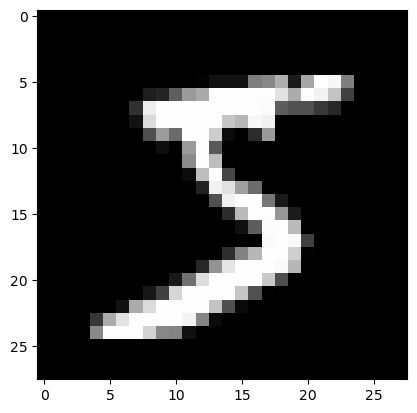

In [25]:
plt.imshow(x_train[0, :].reshape(28, 28), cmap='gray')

In [26]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000, 1), (10000, 784), (10000, 1))

In [28]:
x_train = x_train.T
x_test = x_test.T

In [31]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((784, 60000), (60000, 1), (784, 10000), (10000, 1))

In [44]:
y_train[:, :10]

array([[5],
       [0],
       [4],
       ...,
       [5],
       [6],
       [8]])

In [52]:
digits = 10
m_train = y_train.shape[0]  # 60_000
m_test = y_test.shape[0]  # 10_000

m_train, m_test

(60000, 10000)

In [54]:
y_train_old = y_train
y_test_old = y_test
y_train = np.eye(digits)[y_train.astype('int32')]
y_train = y_train.T.reshape(digits, m_train)

y_test = np.eye(digits)[y_test.astype('int32')]
y_test = y_test.T.reshape(digits, m_test)

In [62]:
print(y_train_old[2, :])
y_train[:, 2]

[4]


array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [63]:
lr = 0.5  # learning rate
epochs = 50  # number of epochs to train
n_x = 784  # number of inputs
n_h = 64  # input batch size
batch_size = 64  # input batch size
batches = m_train // batch_size  # number of batches

In [64]:
# initialization
params = {'A1':np.random.randn(n_h, n_x) * np.sqrt(1 / n_x),
          'b1':np.zeros((n_h, 1)),
          'A2':np.random.randn(digits, n_h) * np.sqrt(1 / n_h),
          'b2':np.zeros((digits, 1))
         }

In [68]:
dA1 = np.zeros(params['A1'].shape)
db1 = np.zeros(params['b1'].shape)
dA2 = np.zeros(params['A2'].shape)
db2 = np.zeros(params['b2'].shape)

In [71]:
def layer_multiplication(A, C, B):
    return np.matmul(A, C) + B

In [72]:
def sigmoid(Z):
    s = 1 / (1 + np.exp(-Z))
    return s

In [73]:
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis=0)

In [75]:
def compute_loss(Y, Y_hat):
    """compute loss function"""
    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = - (1 / m) * L_sum

    return L

In [76]:
def feed_forward(X, params):
    cache = {}

    # Z1 = A1.dot(x) + b1
    cache['Z1'] = layer_multiplication(params['A1'], X, params['b1'])

    # C1 = sigmoid(Z1)
    cache['C1'] = sigmoid(cache['Z1'])

    # Z2 = A2.dot(A1) + b2
    cache['Z2'] = layer_multiplication(params['A2'], cache['C1'], params['b2'])

    # C2 = softmax(Z2)
    cache['C2'] = softmax(cache['Z2'])

    return cache

In [78]:
def back_propagate(X, Y, params, cache, m_batch):
    # error at last layer
    delta_2 = cache['C2'] - Y

    # gradient at last layer (Py2 need 1. to transform to float)
    dA2 = (1 / m_batch) * np.matmul(delta_2, cache['C1'].T)
    db2 = (1 / m_batch) * np.sum(delta_2, axis=1, keepdims=True)

    # back propagate through first layer
    delta_1 = np.matmul(params['A2'].T, delta_2) * (sigmoid(cache['Z1'])) * (1-sigmoid(cache['Z1']))

    # gradients at first layer (Py2 need 1 to transform to float)
    dA1 = (1 / m_batch) * np.matmul(delta_1, X.T)
    db1 = (1 / m_batch) * np.sum(delta_1, axis=1, keepdims=True)

    grads = {'dA1':dA1, 'db1':db1, 'dA2':dA2, 'db2':db2}

    return grads

In [80]:
test_costs = []
train_costs = []

# training
for i in range(epochs):

    # shuffle training set
    permutation = np.random.permutation(x_train.shape[1])
    X_train_shuffled = x_train[:, permutation]
    Y_train_shuffled = y_train[:, permutation]

    for j in range(batches):

        # get mini-batch
        begin = j * batch_size
        end = min(begin + batch_size, x_train.shape[1] - 1)
        X = X_train_shuffled[:, begin:end]
        Y = Y_train_shuffled[:, begin:end]
        m_batch = end - begin

        # forward and backward
        cache = feed_forward(X, params)
        grads = back_propagate(X, Y, params, cache, m_batch)
        
        dA1 = grads["dA1"]
        db1 = grads["db1"]
        dA2 = grads["dA2"]
        db2 = grads["db2"]
        
        # gradient descent
        params["A1"] = params["A1"] - lr * dA1
        params["b1"] = params["b1"] - lr * db1
        params["A2"] = params["A2"] - lr * dA2
        params["b2"] = params["b2"] - lr * db2

    # forward pass on training set
    cache = feed_forward(x_train, params)
    train_loss = compute_loss(y_train, cache["C2"])
    train_costs.append(train_loss)

    # forward pass on test set
    cache = feed_forward(x_test, params)
    test_loss = compute_loss(y_test, cache["C2"])
    test_costs.append(test_loss)

    if i % 10 == 0 or i == epochs-1:
        print(f"Epoch {i+1}: training loss = {train_loss}, test loss = {test_loss}")

Epoch 1: training loss = 0.2533675116380132, test loss = 0.24873565902227365
Epoch 11: training loss = 0.05993177692326472, test loss = 0.0851611700273807
Epoch 21: training loss = 0.031244950438720984, test loss = 0.07213923978684854
Epoch 31: training loss = 0.019853395601791522, test loss = 0.07197245448915922
Epoch 41: training loss = 0.011542681474401005, test loss = 0.07172258709568542
Epoch 50: training loss = 0.008308870573112512, test loss = 0.07442632263533461


In [82]:
def plot_cost(train_costs, test_costs, epochs):
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.plot(epochs, train_costs, 'm', linewidth = '1', color='r', label='mashqdagi xatolik')
    plt.plot(epochs, test_costs, 'm', linewidth = '1', color='g', label='testdagi xatolik')
    plt.legend(loc='upper right')
    plt.show()

C:\Users\JAVOHIR\AppData\Local\Temp\ipykernel_8692\1235243880.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m" (-> color=(0.75, 0.0, 0.75, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train_costs, 'm', linewidth = '1', color='r', label='mashqdagi xatolik')
C:\Users\JAVOHIR\AppData\Local\Temp\ipykernel_8692\1235243880.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m" (-> color=(0.75, 0.0, 0.75, 1)). The keyword argument will take precedence.
  plt.plot(epochs, test_costs, 'm', linewidth = '1', color='g', label='testdagi xatolik')


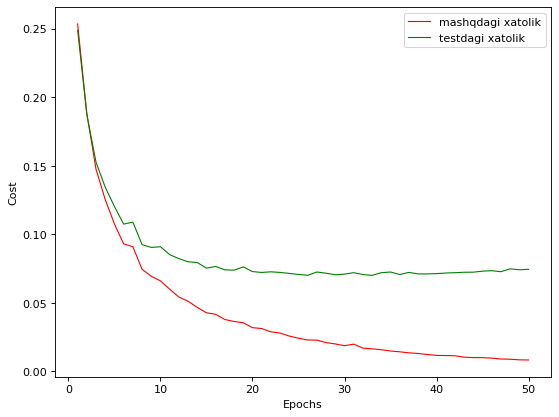

In [84]:
n_epochs = np.arange(1, epochs + 1)
plt.figure(figsize=(8, 6), dpi=80)
plot_cost(train_costs, test_costs, n_epochs)

In [86]:
test_predictions = feed_forward(x_test, params)['C2']
test_predictions

In [88]:
test_predictions_label = np.argmax(test_predictions, axis=0)
test_predictions_label

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [92]:
y_test_old

array([[7],
       [2],
       [1],
       ...,
       [4],
       [5],
       [6]])

In [93]:
y_test_old_ = np.ravel(y_test_old)
y_test_old_

array([7, 2, 1, ..., 4, 5, 6])

In [101]:
# https://stackoverflow.com/a/53387268/4361020
def confusion_matrix(actual, predicted):
    classes = np.unique(np.concatenate((actual, predicted)))
    confusion_mtx = np.empty((len(classes), len(classes)), dtype=int)
    for i, a in enumerate(classes):
        for j, p in enumerate(classes):
            confusion_mtx[i,j] = np.where((actual==a) * (predicted==p))[0].shape[0]
    return confusion_mtx

In [107]:
cf = confusion_matrix(y_test_old_, test_predictions_label)
cf

array([[ 968,    1,    1,    1,    0,    2,    2,    1,    1,    3],
       [   0, 1123,    4,    1,    0,    1,    2,    1,    3,    0],
       [   3,    0, 1006,    7,    3,    0,    3,    6,    3,    1],
       [   1,    0,    2,  992,    0,    5,    0,    3,    4,    3],
       [   1,    0,    3,    0,  960,    0,    2,    1,    1,   14],
       [   3,    1,    0,   10,    0,  868,    4,    1,    3,    2],
       [   3,    3,    4,    1,    1,    3,  940,    0,    2,    1],
       [   0,    3,    8,    6,    2,    0,    0,  996,    2,   11],
       [   4,    0,    2,    9,    6,    4,    4,    0,  943,    2],
       [   3,    4,    0,    7,   10,    4,    0,    4,    1,  976]])

In [105]:
for i in range(10):
    # printing labels
    if i == 0:
        print

array([[ 968,    1,    1,    1,    0,    2,    2,    1,    1,    3],
       [   0, 1123,    4,    1,    0,    1,    2,    1,    3,    0],
       [   3,    0, 1006,    7,    3,    0,    3,    6,    3,    1],
       [   1,    0,    2,  992,    0,    5,    0,    3,    4,    3],
       [   1,    0,    3,    0,  960,    0,    2,    1,    1,   14],
       [   3,    1,    0,   10,    0,  868,    4,    1,    3,    2],
       [   3,    3,    4,    1,    1,    3,  940,    0,    2,    1],
       [   0,    3,    8,    6,    2,    0,    0,  996,    2,   11],
       [   4,    0,    2,    9,    6,    4,    4,    0,  943,    2],
       [   3,    4,    0,    7,   10,    4,    0,    4,    1,  976]])

In [108]:
for i in range(10):
    #printing labels
    if i ==0:
        print('\t', end='')
        for j in range(10):
            print('b:', j, end='\t')
        print('\n')
    
    print('t:', i, end='\t')
    for j in range(10):
        print(cf[i][j], end='\t')
    print('\n')

	b: 0	b: 1	b: 2	b: 3	b: 4	b: 5	b: 6	b: 7	b: 8	b: 9	

t: 0	968	1	1	1	0	2	2	1	1	3	

t: 1	0	1123	4	1	0	1	2	1	3	0	

t: 2	3	0	1006	7	3	0	3	6	3	1	

t: 3	1	0	2	992	0	5	0	3	4	3	

t: 4	1	0	3	0	960	0	2	1	1	14	

t: 5	3	1	0	10	0	868	4	1	3	2	

t: 6	3	3	4	1	1	3	940	0	2	1	

t: 7	0	3	8	6	2	0	0	996	2	11	

t: 8	4	0	2	9	6	4	4	0	943	2	

t: 9	3	4	0	7	10	4	0	4	1	976	



In [109]:
def calculate_f1_score_accuracy(cf, n):
    actual_sum = np.sum(cf, axis=1)
    predicted_sum = np.sum(cf, axis=0)
    print('raqam \t precision \t recall \t f1-score haqiqiy_klasslar soni')
    total_correct_sum = 0
    for i in range(10):
        correct_sum = cf[i][i]
        total_correct_sum += correct_sum
        precision = correct_sum / predicted_sum[i]
        recall = correct_sum / actual_sum[i]
        f1_score = 2 * precision * recall / (precision + recall)
        print(i, '\t', round(precision, 5), '\t', round(recall, 5),'\t', round(f1_score, 5),'\t', actual_sum[i])
    total_accuracy = total_correct_sum / n
    print('Accuracy: ', total_accuracy)

In [110]:
calculate_f1_score_accuracy(cf, m_test)

raqam 	 precision 	 recall 	 f1-score haqiqiy_klasslar soni
0 	 0.98174 	 0.98776 	 0.98474 	 980
1 	 0.98943 	 0.98943 	 0.98943 	 1135
2 	 0.9767 	 0.97481 	 0.97575 	 1032
3 	 0.95938 	 0.98218 	 0.97065 	 1010
4 	 0.9776 	 0.9776 	 0.9776 	 982
5 	 0.97858 	 0.97309 	 0.97583 	 892
6 	 0.98224 	 0.98121 	 0.98172 	 958
7 	 0.98322 	 0.96887 	 0.97599 	 1028
8 	 0.97923 	 0.96817 	 0.97367 	 974
9 	 0.96347 	 0.96729 	 0.96538 	 1009
Accuracy:  0.9772
